In [1]:
from collections import Counter
import copy
from datetime import datetime
import os
from pathlib import Path
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ray import tune
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummaryX import summary
from torch.utils.tensorboard import SummaryWriter
import watermark
import Levenshtein

In [3]:
#%load_ext pycodestyle_magic
#%%pycodestyle

In [4]:
if torch.cuda.is_available():
    print('GPU support: %s' % torch.cuda.get_device_name(0))
else:
    print('No GPU was detected!')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Torch device:', device)

GPU support: GeForce RTX 2080
Torch device: cuda:0


In [5]:
%load_ext watermark
%watermark --iversions

numpy      1.18.3
watermark  1.8.1
torch      1.5.0
ray        0.8.4
seaborn    0.10.0
matplotlib 3.2.1
pandas     1.0.3



In [6]:
assert sys.version_info >= (3, 5)
assert torch.__version__ >= "1.4.0"

In [7]:
CONFIG = {
    'phonemes': [
        "'", ' ', 'i', 'e', 'ɛ', 'a', 'ɑ', 'ɔ', 'o', 'u', 'y',
        'ø', 'œ', 'ə', 'ɛ̃', 'ɑ̃', 'ɔ̃', 'œ̃', 'j', 'w', 'ɥ',
        'p', 't', 'k', 'b', 'd', 'ɡ', 'f', 's', 'ʃ', 'v',
        'z', 'ʒ', 'l', 'ʁ', 'm', 'n', 'ɲ', 'ŋ'
    ],
    'dictionary_source_file': 'fr_wiktionary_excerpt.csv',
    'dictionary_file': 'fr_wiktionary_temp.csv',
    'data_order': 'alphabetical',
    'shuffle': True,
    'mfccs_mean': -11.48,
    'mfccs_std': 80.30,
    'model_filename': 'gipfa-all.pt',
    'fit_on_accuracy': False,
    'time_max': 2.0,
    'T': 87,
    'validation_split': 0.01,
    'patience_max': 3,
    'root_dir': '.',
    'n_max_phonemes': 20,
    'mfcc': 40,
    'episodes': 11,
    'epochs': 100, 
    'speakers': [''],
    'n_train': 100000,
    'n_test': 1000,
    'n_per_batch': 20,
    'optimizer': 'AdamW',
    'lr': 1e-4,
    'conv_activation': 'relu',
    'conv_layers': 2,
    'conv_units': 128,
    'conv_bn': True,
    'lstm_layers': 2,
    'lstm_units': 512,
    'lstm_dropout': 0.5,
    'lstm_bidirectional': True,
    'lstm_bn': True,
    'fc_activation': 'none', 
    'best_episode': 0,
    'best_accuracy': 1e-10,
    'best_loss': 1e10,
    'char_2_int': {},
    'int_2_char': {},
}

# update config with two additional parameters related to phonemes
for i in range(len(CONFIG['phonemes'])):
    ch = CONFIG['phonemes'][i]
    CONFIG['char_2_int'][ch] = i
    CONFIG['int_2_char'][i+1] = ch

In [8]:

def get_best_model_filename(config):
    return config['model_filename'].replace('.pt', '_best.pt')

def get_audio_dir(config):

    if config['mfcc'] == 0:
        audio_dir = 'audio/'
    else:
        audio_dir = config['root_dir'] + '/' + 'mfcc_' \
        + str(config['time_max']) + '_' + str(config['mfcc']) + '/' 
        
    return audio_dir

In [9]:
def get_phonemes(pronunciation):

    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i] == '̃':
                continue
            if pronunciation[i+1] == '̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i] == '̃':
                continue
            else:
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes


def get_padded_phonemes(pronunciation, str_len_max):

    padded_phonemes = get_phonemes(pronunciation)
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes


def get_tk_padded_phonemes(pronunciation, str_len_max, config):

    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(config['char_2_int'][phoneme])

    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)

    return np_array


assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6, CONFIG),
                      np.array([[22, 14, 24, 34,  0,  0]]))


def get_pronunciation(padded_phonemes):

    pronunciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            pronunciation += padded_phoneme

    return pronunciation


assert get_pronunciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [10]:
def get_audio_files_names(audio_files_str, speakers=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        audio_files_str = audio_files_str.replace('""',"'") 
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if not speakers:
                audio_file_names2.append(audio_file_name)
            else:
                for speaker in speakers:
                    if speaker in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names


assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("['a', 'b', 'c']") == ['a', 'b', 'c']
assert get_audio_files_names("['foo-a', 'bar-b']", ['bar']) == ['bar-b']
assert get_audio_files_names("['foo-a', 'bar-b', 'car-c', 'foo-d']",
                             ['bar', 'foo']) == ['foo-a', 'bar-b', 'foo-d']

In [11]:
allowed_IPA_letters = [
    'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 's', 't', 'u', 'v', 'w', 'y',
    'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
    'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'
]

verbose_IPA_letters = [
    '(', ')', '‿', '.', ' ', '͡', '-', 'ˈ', 'ː'
]
            

''' Retrieve the dataset
'''
DONE_ONCE_PER_EPISODE = False

def set_dataframes(config):
    
    global DONE_ONCE_PER_EPISODE
    global DF
    global DF_TRAIN
    global DF_TEST
    
    if not DONE_ONCE_PER_EPISODE:    
        DF = pd.read_csv(config['dictionary_file'], sep='\t')
        print('dictionary_file:', config['dictionary_file'])
        print(DF.head(1))
        DF_TRAIN = DF.head(DF.shape[0] - config['n_test'])
        DF_TEST = DF.head(DF.shape[0] - config['n_test']).copy()
        DF_TEST = DF_TEST.reset_index()
        DONE_ONCE_PER_EPISODE = True

def get_data(config,
             n_max=sys.maxsize,  
             index_min=0, index_max=sys.maxsize, 
             train = False, test = False,
             verbose=False, verbose2=False):
    
    global DF
    global DF_TRAIN
    global DF_TEST
    
    set_dataframes(config)
    
    dict_file = config['dictionary_file']
    n_max_phonemes = config['n_max_phonemes']
    
    audio_dir = get_audio_dir(config)
    if verbose:
        print('audio_dir:', audio_dir)
    
    if verbose:
        print('dict_file:', dict_file)
    
    if not train and not test:
        print('get_data train=False and test=False: can not handle')
        return 
    
    # identify which data are wanted
    if train and not test:
        df = DF_TRAIN
    elif not train and test:
        df = DF_TEST
    elif train and test:
        df = DF
    else: # not train and not test:
        print('get_data train=False and test=False: can not handle')
        return
    
    #print('get_data df.shape[0]', df.shape[0])
    
    # read 1 mfcc file to learn the maximum shape of the samples
    # in the directory
    audio_shape_t = 0 # should lead to T
    audio_shape_d = 0 # should lead to 40 or 90

    batch_size = df.loc[index_min:index_max].shape[0]
    if batch_size == 0:
        print('ERROR get_data: no data in dataframe between index %d and %d' % (index_min, index_max))
        return 0
    
    for index, row in df.loc[index_min:index_max, :].iterrows():

        audio_file = ''
        wav_file = row['Audio']
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        if verbose:
            print('wav_file=*%s*' % wav_file)
        audio_file = wav_file.replace('.wav', '.npy')
        audio_filename = audio_dir + audio_file

        if os.path.exists(audio_filename):
            mfcc = np.load(audio_filename)
            audio_shape_t = max(audio_shape_t, mfcc.shape[1])
            audio_shape_d = mfcc.shape[0]
            break
        else:
            if verbose2:
                print('audio_file=*%s* not found !!!' % audio_file)
    if audio_shape_t == 0:
        print('audio_shape_t not found !!!')
        return 0

    if verbose:        
        print('audio_shape_t:%d' % audio_shape_t)
        print('audio_shape_d:%d' % audio_shape_d)

    if n_max==sys.maxsize or n_max > df.shape[0]:
        n_max = df.shape[0]
    if verbose2:
        print('n_max:', n_max)
    
    if index_max == sys.maxsize:
        index_max = index_min + n_max
    if verbose2:        
        print('n_max:%d' % n_max)
        print('index_min:%d' % index_min)
        print('index_max:%d' % index_max)
        print('df.shape[0]:%d' % df.shape[0])

    n_ok = 0
    n_ko = 0

    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, audio_shape_t, audio_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    indexes = np.zeros((n_max, 1))    
    
    # iterate over the lines of the wanted slice (aka rows)
    for index, row in df.loc[index_min:index_max, :].iterrows(): 
        wav_file = row['Audio']
        audio_file = wav_file.replace('.wav','.npy')
        
        if audio_file == '':
            print('+!')
            continue

        audio_filename = audio_dir + audio_file
        if os.path.exists(audio_filename):
            mfcc = np.load(audio_filename)
            #if verbose2:
            #    print('mfcc.shape:', mfcc.shape)

            '''
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Word'])
                except:
                    print('#')
                continue
            '''
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]

            # fetch the pronunciation
            word = row['Word']
            pronunciation = row['Pronunciation']
            
            # remove unnecessary IPA symbols from the pronunication
            for s in verbose_IPA_letters:
                pronunciation = pronunciation.replace(s, '')
            
            phonemes = get_tk_padded_phonemes(pronunciation, n_max_phonemes, config)

            # add the mfcc in the mfccs table
            phonemess[n_ok, :] = phonemes
            indexes[n_ok:] = index 
            n_ok += 1
            
            # A améliorer !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #if config['speakers'] == '':
            if n_ok == n_max:
                break
            #elif n_ok == (config['n_train'] + config['n_test']):
            #break
        else:
            if verbose2:
                print('file ko:', audio_file)
            n_ko += 1

    if verbose:
        print('n_max:', n_max)
        print('n_ok:', n_ok)
        print('n_ko:', n_ko)

    # delete unused rows
    mfccs = mfccs[:n_ok, :, :]
    phonemess = phonemess[:n_ok]
    indexes = indexes[:n_ok]

    if verbose2:
        print('mfccs.shape:', mfccs.shape)
        print('phonemess.shape:', phonemess.shape)
        print('indexes.shape:', indexes.shape)

    # standardize data
    mfccs -= config['mfccs_mean']
    mfccs /= config['mfccs_std']
        
    return mfccs, phonemess, indexes

In [14]:
def preprocess_data(config, verbose=False):
    
    source_file = config['dictionary_source_file']    
    print('preprocess source_file:', source_file)
    df = pd.read_csv(source_file, sep='\t', comment='#')
        
    # trick to  make ray tune (which works with string)
    # working with lists
    if isinstance(config['speakers'], str):
        config['speakers'] = [ config['speakers'] ]
        
    print("preprocess_data speakers:", config['speakers'])
    indexes_to_drop = []
    if config['speakers']:
        for index, row in df.iterrows():
            keep_audio_sample = False
            for speaker in config['speakers']:
                if speaker in row['Audio']:
                    keep_audio_sample = True
                    break
            if not keep_audio_sample:
                indexes_to_drop.append(index)
        print('len indexes_to_drop:', len(indexes_to_drop))
        df = df.drop(indexes_to_drop)
        
    if config['shuffle']:
        df = df.sample(frac=1).reset_index(drop=True)
    
    dest_file = config['dictionary_file']
    print('preprocess dest_file:', dest_file)
    df.to_csv(dest_file, index=False, sep='\t')
    
    n_train = config['n_train']
    n_test = config['n_test']
    n = df.shape[0]
    if n <= n_test:
        print('preprocess: ERROR wanted n_test:%d, found only %d samples' % (n_test, n))
    elif n_train + n_test > n:
        print('preprocess: WARNING reduce n_train:%d to n_train:%d' % (n_train, n - n_test))
        config['n_train'] = n - n_test
    
    return config

In [15]:
# Define the model
class ASR(nn.Module):

  def __init__(self, config):

    super(ASR, self).__init__()
    
    self.T = config['T']
    self.D = config['mfcc']
    self.C = len(config['char_2_int'].keys()) + 1
    
    self.conv_activation=config['conv_activation']
    self.conv_layers = config['conv_layers']
    self.conv_bn = config['conv_bn']
    self.lstm_layers = config['lstm_layers']
    self.lstm_bn = config['lstm_bn']
    self.fc_activation = config['fc_activation']

    self.first_time = False


    #torch.nn.Conv1d(in_channels, out_channels, kernel_size,
    #                stride=1, padding=0, dilation=1, groups=1,
    #                bias=True, padding_mode='zeros')
    if self.conv_layers == 0:
        conv_out = self.D
    if self.conv_layers >= 1:
        self.layers = self.conv_layers
        conv_out = config['conv_units'] 
        self.conv1 = nn.Conv1d(self.D, conv_out, 3, stride=1, padding=1)
        if config['conv_bn']:
            self.bn1 = nn.BatchNorm1d(conv_out)
    if self.conv_layers >= 2:
        conv_in = conv_out
        conv_out = conv_in * 2
        self.conv2 = nn.Conv1d(conv_in, conv_out, 3, stride=1, padding=1)
        if config['conv_bn']:
            self.bn2 = nn.BatchNorm1d(conv_out)
    if self.conv_layers >= 3:
        conv_in = conv_out
        conv_out = conv_in * 2
        self.conv3 = nn.Conv1d(conv_in, conv_out, 3, stride=1, padding=1)
        if config['conv_bn']:
            self.bn3 = nn.BatchNorm1d(conv_out)
    if self.conv_layers >= 4:
        print('CAN NOT ALLOW CONV_LAYERS=%d, ALLOCATED:3' % self.conv_layers)

    if self.lstm_layers > 0:
        self.lstm = nn.LSTM(input_size=conv_out,
                            hidden_size=config['lstm_units'],
                            num_layers=self.lstm_layers,
                            dropout=config['lstm_dropout'],
                            bidirectional=config['lstm_bidirectional'],
                            batch_first=True,
                           )
        if config['lstm_bn']:
            self.bn_lstm = nn.BatchNorm1d(self.T)

        if config['lstm_bidirectional']:
            units_out = config['lstm_units'] * 2
        else:
            units_out = config['lstm_units']
    else:
        units_out = conv_out

    self.fc = nn.Linear(units_out, self.C)




  def forward(self, X, verbose=True):

    # embedding layer
    # turns word indexes into word vectors
    data = X

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    if self.conv_layers >= 1:
        if verbose and self.first_time:
            print('')
            print('Data shapes:')
            print('before permute data.shape:', data.shape)
        data = data.permute(0, 2, 1)

    if self.conv_layers >= 1:
        if verbose and self.first_time:
            print('before conv1 data.shape:', data.shape)
        data = self.conv1(data)
        if self.conv_bn:
            data = self.bn1(data)
        if verbose and self.first_time:
            print('before relu1 data.shape:', data.shape)
        if self.conv_activation=='relu':
            data = torch.relu(data)
        elif self.conv_activation=='tanh':
            data = torch.tanh(data)
        #data = self.pool1(data)

    if self.conv_layers >= 2:
        if verbose and self.first_time:
            print('before conv2 data.shape:', data.shape)
        data = self.conv2(data)
        if self.conv_bn:
            data = self.bn2(data)
        if verbose and self.first_time:
            print('before relu2 data.shape:', data.shape)
        if self.conv_activation=='relu':
            data = torch.relu(data)
        elif self.conv_activation=='tanh':
            data = torch.tanh(data)
        #data = self.pool2(data)

    if self.conv_layers >= 3:
        if verbose and self.first_time:
            print('before conv3 data.shape:', data.shape)
        data = self.conv3(data)
        if self.conv_bn:
            data = self.bn3(data)
        if verbose and self.first_time:
            print('before relu3 data.shape:', data.shape)
        if self.conv_activation=='relu':
            data = torch.relu(data)
        elif self.conv_activation=='tanh':
            data = torch.tanh(data)
        #data = self.pool3data)

    if self.conv_layers >= 1:
        if verbose and self.first_time:
            print('before permute data.shape:', data.shape)
        data = data.permute(0, 2, 1)

    if self.lstm_layers >= 1:
        if verbose and self.first_time:
            print('before bi-lstm data.shape:', data.shape)
        data, states = self.lstm(data)

        if self.lstm_bn:
            data = self.bn_lstm(data)

    # max pool
    #out, _ = torch.max(out, self.K)
    if verbose and self.first_time:
        print('before fc data.shape::', data.shape, '\n')
    # final dense layer
    data = self.fc(data)
    if self.fc_activation=='relu':
        data = torch.relu(data)
    elif self.fc_activation=='tanh':
        data = torch.tanh(data)
    elif self.fc_activation=='gelu':
        data = torch.gelu(data)

    if verbose and self.first_time:
        print('after fc data.shape::', data.shape, '\n')

    return data

In [16]:
FIRST_TIME_EVER = True

In [18]:
def get_training_sizes(mfccs, phonemes, config, verbose=False):


    N = mfccs.shape[0]
    if verbose:
        print('N:%d (Number of samples)', N)
    
    T = mfccs.shape[1]
    if verbose:
        print('T:%d (Time units)', T)

    assert mfccs.shape[2] == config['mfcc']
    D = mfccs.shape[2]
    if verbose:
        print('D:%d (Data units (frequency samples))', D)

    input_length = np.zeros([N])
    for i in range(N):
        input_length[i] = T #43 # 87
    if verbose:
        print('input_length[0:2]:', input_length[0:2])
        print('input_length.shape', input_length.shape)

    assert phonemes.shape[1] == config['n_max_phonemes']
    label_length = np.zeros([N])
    for i in range(N):
        label_length[i] = phonemes.shape[1]
    if verbose:
        print('label_length[0:2]:', label_length[0:2])

    C = len(config['char_2_int'].keys()) + 1
    
    return N, T, D, C, input_length, label_length


In [19]:
def get_model(config):

    model = ASR(config)
    model.to(device)
    
    #import nn.CrossEntropyLoss
    # Loss and optimizer
    criterion = nn.CTCLoss(blank=1).to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-07)
    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    else:
        print('optimizer:%s not implemented!' % config['model'])
    
    return model, criterion, optimizer

In [20]:
# A function to encapsulate the training loop
def fit(model, criterion, optimizer, config, episode=0, verbose=False, verbose2=False):
    
    epochs = config['epochs']
    fit_on_accuracy = config['fit_on_accuracy']
    n = config['n_train']
    n_per_batch = config['n_per_batch']
    batches = n // n_per_batch
    batches_eval = max(int(batches * config['validation_split']), 1)
    batches_train = batches - batches_eval
    
    if verbose:
        print('fit: batches:%d' % batches)
        print('fit: batches_train:%d' % batches_train)
        print('fit: batches_eval:%d' % batches_eval)
    print('fit: batches:%d (train:%d, eval:%d)' % (batches, batches_train, batches_eval))
    print('fit: train_samples:%d, eval_samples:%d' % (batches_train*n_per_batch, batches_eval*n_per_batch))
    
    patience_max = config['patience_max']
    
    train_losses = np.zeros(epochs)
    eval_losses = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    eval_accuracies = np.zeros(epochs)
    
    eval_loss_min = 0.0
    eval_accuracy_max = 0.0
    patience = 0
    
    for it in range(epochs):        
        if verbose:
            print('it:', it)
        t0 = datetime.now()
        train_loss = []
        train_accuracy = []
        for b in range(batches_train):
            if verbose:
                print('b (train):%d index_min:%d index_max:%d' % (b, b*n_per_batch, (b+1)*n_per_batch))
            
            X_train, Y_train, indexes_train = get_data(config,
                                                       n_per_batch,
                                                       index_min=b*n_per_batch,
                                                       index_max=(b+1)*n_per_batch,
                                                       train=True)
            N, T, D, C, input_length, label_length = get_training_sizes(X_train, Y_train, config)
            inputs = torch.from_numpy(X_train).float()
            #print('inputs shape:',inputs.shape)
            targets = torch.from_numpy(Y_train).float()
            #print('input_lenghts shape:',input_l
            input_lenghts = torch.from_numpy(input_length).short()
            target_lenghts = torch.from_numpy(label_length).short()
            
            #print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
            #targets = targets.view(-1, 1).float()
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
 
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            
            loss1 = criterion(probs, targets, input_lenghts, target_lenghts)
        
            # Backward and optimize
            loss1.backward()
            optimizer.step()

            train_loss.append(loss1.item())
            
            
            # optionally, measure the train accuracy
            # ======================================
            if fit_on_accuracy:
                predicted = model(inputs.to(device))
                phonemess, target_phonemess = decode_predictions(predicted, targets, config)            
                if verbose2:
                    debug_str = '[WORD] /DICTIONARY PRONUNCIATION/ vs /PREDICTED PRONUNCIATION/<br>'
                targets = []
                predictions = []
                df_results = None    
                n_ok = 0
                n_ko = 0
                n_tested = 0
                for i in range(X_train.shape[0]):
                    phonemes = phonemess[i]
                    target_phonemes = target_phonemess[i]

                    if verbose2:
                        debug_str = '/' + target_phonemes + '/ vs '

                    targets.append(target_phonemes)
                    predictions.append(phonemes)
                    if verbose2:
                            debug_str += '/' + phonemes + '/'
                    n_tested += 1
                    if phonemes == target_phonemes:
                        n_ok += 1
                        prediction_res = True
                    else:
                        n_ko += 1
                        prediction_res = False
                accuracy = n_ok/n_tested
                train_accuracy.append(np.array(accuracy))

        train_loss = np.mean(train_loss) # a little misleading
        if fit_on_accuracy:
            train_accuracy = np.mean(train_accuracy)
        

        # EVALUATION STEP
        
        eval_loss = []
        eval_accuracy = []
        for b in range(batches_train, batches_train+batches_eval):
            if verbose:
                print('b (eval):%d' % b)
            X_eval, Y_eval, indexes_eval = get_data(config,
                                                    n_per_batch,
                                                    index_min=b*n_per_batch,
                                                    index_max=(b+1)*n_per_batch,
                                                    train=True)
            N, T, D, C, input_length, label_length = get_training_sizes(X_eval, Y_eval, config)
            inputs = torch.from_numpy(X_eval).float()
            targets = torch.from_numpy(Y_eval).float()
            inputs, targets = inputs.to(device), targets.to(device)
            input_lenghts = torch.from_numpy(input_length).short()
            target_lenghts = torch.from_numpy(label_length).short()
      
            #targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            loss2 = criterion(probs, targets, input_lenghts, target_lenghts)
            eval_loss.append(loss2.item())
        

            # optionnally, measure the eval accuracy
            # ======================================
            if fit_on_accuracy:
                predicted = model(inputs.to(device))
                phonemess, target_phonemess = decode_predictions(predicted, targets, config)            
                if verbose2:
                    debug_str = '[WORD] /DICTIONARY PRONUNCIATION/ vs /PREDICTED PRONUNCIATION/<br>'
                targets = []
                predictions = []
                df_results = None    
                n_ok = 0
                n_ko = 0
                n_tested = 0
                for i in range(X_eval.shape[0]):
                    phonemes = phonemess[i]
                    target_phonemes = target_phonemess[i]

                    if verbose2:
                        debug_str = '/' + target_phonemes + '/ vs '

                    targets.append(target_phonemes)
                    predictions.append(phonemes)
                    if verbose2:
                            debug_str += '/' + phonemes + '/'
                    n_tested += 1
                    if phonemes == target_phonemes:
                        n_ok += 1
                        prediction_res = True
                    else:
                        n_ko += 1
                        prediction_res = False
                accuracy = n_ok/n_tested
                eval_accuracy.append(np.array(accuracy))
            
                
        eval_loss = np.mean(eval_loss)
        if fit_on_accuracy:
            eval_accuracy = np.mean(eval_accuracy)
        
        # Save losses
        train_losses[it] = train_loss
        eval_losses[it] = eval_loss
        if fit_on_accuracy:
            train_accuracies[it] = train_accuracy
            eval_accuracies[it] = eval_accuracy
        
        dt = datetime.now() - t0
        if fit_on_accuracy:
            print('epoch:%d/%d (%ss) train_loss:%.2f, eval_loss:%.2f, train_accuracy:%.2f, eval_accuracy:%.2f'
                  % (it+1, epochs, dt.seconds, train_loss, eval_loss, train_accuracy, eval_accuracy))
            
            if eval_accuracy > config['best_accuracy']:
                config['best_accuracy'] = eval_accuracy
                config['best_episode'] = episode
                torch.save(model.state_dict(), get_best_model_filename(config))
                
            if it==0:
                eval_accuracy_max = eval_accuracy
                torch.save(model.state_dict(), config['model_filename'])
                #print('INIT eval_accuracy_max:%f', eval_accuracy_max)
            elif eval_accuracy > eval_accuracy_max:
                eval_accuracy_max = eval_accuracy
                torch.save(model.state_dict(), config['model_filename'])
                print('NEW BEST eval_accuracy:%.2f' % eval_accuracy_max)
                patience = 0
            else:
                #print('(old) eval_accuracy_max:%f', eval_accuracy_max)
                patience += 1
                if patience == patience_max:
                    print('Patience max reached, break')
                    break
                    
        else:
            print('epoch:%d/%d (%ss) train_loss:%.2f, eval_loss:%.2f'
                  % (it+1, epochs, dt.seconds, train_loss, eval_loss))

            if eval_loss < config['best_loss']:
                config['best_loss'] = eval_loss
                config['best_episode'] = episode
                torch.save(model.state_dict(), get_best_model_filename(config))
                
            if it==0:
                eval_loss_min = eval_loss
                torch.save(model.state_dict(), config['model_filename'])
                #print('INIT eval_loss_min:%f', eval_loss_min)
            elif eval_loss < eval_loss_min:
                eval_loss_min = eval_loss
                torch.save(model.state_dict(), config['model_filename'])
                print('NEW BEST eval_loss:%.2f' % eval_loss_min)
                patience = 0
            else:
                #print('(old) eval_loss_min:%f', eval_loss_min)
                patience += 1
                if patience == patience_max:
                    print('Patience max reached, break')
                    break
                
    # return stored model, which is the best one
    model.load_state_dict(torch.load(get_best_model_filename(config)))
    
    #tune.track.log(mean_loss=eval_loss_min)

    
    return model, train_losses[0:it+1], eval_losses[0:it+1]        

In [21]:
def display_learning_curves(train_losses, eval_losses):
    # Plot the train loss and test loss per iteration
    #plt.ion()
    _ = plt.plot(train_losses, label='train loss')
    _ = plt.plot(eval_losses, label='eval loss')
    _ = plt.legend()
    _ = plt.show()
    #plt.pause(0.001)
    #input("Press [enter] to continue.")

In [22]:
def decode_predictions(output, labels, config, verbose=False):
    #print('output.shape:', output.shape)
    arg_maxes = torch.argmax(output, dim=2)
    #print('arg_maxes:',arg_maxes)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = ''
        target = ''
        previous_letter = '@'
        if verbose:
            print('i:',i)
            print('args:',args)
            print('labels[i]:',labels[i])
            print('labels[i][:label_lengths[i]]:', labels[i][:int(label_lengths[i])])
        
        for j, index_ in enumerate(labels[i]):
            index = index_.item()
            target_letter = config['int_2_char'][index+1]
            if verbose:
                print('target_letter:%s' % target_letter)
            if target_letter != ' ' and target_letter !="'":
                target += target_letter
        
        if verbose:
            print('target:',target)
        targets.append(target)
        for j, index_ in enumerate(args):
            index = index_.item()
            predicted_letter = config['int_2_char'][index+1]
            if verbose:
                print('letter:%s' % predicted_letter)
            if predicted_letter != ' ' and predicted_letter !="'" and predicted_letter != previous_letter:
                decode += predicted_letter
                previous_letter = predicted_letter
        if verbose:
            print("decoded:", decode)
        decodes.append(decode)
    return decodes, targets

In [23]:
def test(model, config, all_samples=False, detailed_results=False, verbose1=False, verbose2=False):
     
    # for time performance, avoid reading the dataframe whenever possible
    if detailed_results or all_samples:
        df_ref = pd.read_csv(config['dictionary_file'], sep='\t')
    
    if all_samples:
        n = df_ref.shape[0]
    else:
        n = config['n_test']
                
    n_per_batch = config['n_per_batch']
    batches = n // n_per_batch
    
    print('test: %d bacthes of %d samples' % (batches, n_per_batch))
    print('test: samples:%d' % (batches * n_per_batch))    
    
    n_tested = 0
    n_ok = 0
    n_ko = 0
    
    if detailed_results:
        cols = ['Word', 'Audio', 'Pronunciation', 'Predicted_Pronunciation', 'Result']
        df_results = pd.DataFrame(columns=cols)
    else:
        df_results = None
     
    for b in range(batches):

        X, Y, indexes = get_data(config,
                                 n_per_batch,
                                 index_min=b*n_per_batch,
                                 index_max=(b+1)*n_per_batch,
                                 test=True, train=all_samples)        
        
        inputs = torch.from_numpy(X).float()
        labels = torch.from_numpy(Y).float()

        #inputs, targets = inputs.to(device), labels.to(device)
        #inputss = inputs.to(device)
        predicted = model(inputs.to(device))
        phonemess, target_phonemess = decode_predictions(predicted, labels, config)

        if verbose2:
            debug_str = '[WORD] /DICTIONARY PRONUNCIATION/ vs /PREDICTED PRONUNCIATION/<br>'

        targets = []
        predictions = []

        for i in range(X.shape[0]):
            phonemes = ''
            if detailed_results:
                index = int(indexes[i])
                word = df_ref.at[index, 'Word']
                pronunciation = df_ref.at[index, 'Pronunciation']
                audio = df_ref.at[index, 'Audio']
                
            if verbose2:
                if detailed_results:
                    debug_str = '[' + word + ']' + '/' + pronunciation + '/ : '
                else:
                    debug_str = ''

            phonemes = phonemess[i]
            target_phonemes = target_phonemess[i]

            if verbose2:
                debug_str += '/' + target_phonemes + '/ vs '

            targets.append(target_phonemes)
            predictions.append(phonemes)
            if verbose2:
                    debug_str += '/' + phonemes + '/'
            n_tested += 1
            if phonemes == target_phonemes:
                n_ok += 1
                prediction_res = True
            else:
                n_ko += 1
                prediction_res = False
            if detailed_results:
                df_results = df_results.append({'Word': word, 
                                                'Audio': audio, 
                                                'Pronunciation': pronunciation, 
                                                'Predicted_Pronunciation': phonemes, 
                                                'Result': prediction_res}, 
                                                ignore_index=True)
        print('.', end='')

    ok_out_of_100 = round(n_ok/n_tested*100)
    ko_out_of_100 = round(n_ko/n_tested*100)
    accuracy = n_ok/n_tested
    
    if verbose1:
        #print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))
        print()
        print('Prediction results: %d%% ok and %d%% ko (out of %d samples tested)' % \
                (ok_out_of_100, ko_out_of_100, n_tested))
    
    return accuracy, ok_out_of_100, ko_out_of_100, targets, predictions, df_results

In [24]:
def print_model_summary():
    print('size of the model:')
    _ = summary(ASR(CONFIG), torch.zeros(1, CONFIG['T'], CONFIG['mfcc']))

In [25]:
# Main loop
def train_and_test(config, episode=0):
    
    # train
    model, criterion, optimizer = get_model(config)
    t0 = datetime.now()
    model, train_losses, test_losses = fit(model, criterion, optimizer, config, episode)
    t1 = datetime.now()
    train_duration = t1 - t0
    print('train_duration:', train_duration)
    
    # display training figures
    display_learning_curves(train_losses, test_losses)
    
    # test
    t0 = datetime.now()
    accuracy, n_ok, n_ko, targets, predictions, df_results = test(model,
                                                                  config,
                                                                  all_samples=False,
                                                                  detailed_results=False,                                                                 
                                                                  verbose1 = True)
    t1 = datetime.now()
    test_duration = t1 - t0
    print('test_duration:', test_duration)
    
    return model, n_ok, n_ko

## Fine-Tuning

In [26]:
def get_6_digits():
    str_digits =  ''
    for i in range(6):
        digit = random.randint(0,9)
        str_digits += str(digit)
    return(str_digits)

def ray_train_and_test(config, episode, verbose=False):
    
    # train
    t0 = datetime.now()
    config = preprocess_data(config)
    t1 = datetime.now()
    preprocess_data_duration = t1 - t0
    if verbose:
        print('preprocess_data_duration', preprocess_data_duration)
    
    model, criterion, optimizer = get_model(config)
    model, train_losses, eval_losses = fit(model, criterion, optimizer, config, episode)
    
    display_learning_curves(train_losses, eval_losses)
    
    # test
    accuracy, _, _, _, _, _ = test(model,
                                   config,
                                   all_samples=False,
                                   detailed_results=None,
                                   verbose1 = True)
    
    if verbose:
        print('ray_train_and_test() accuracy:', accuracy)
        print('==================================================')
    
    return accuracy

In [27]:
# In order that this function works, you need to extract the
# ASR model in a standalone .py file
def ray_test_hyperparameters():
    
    FINETUNING_CONFIG = {
        'phonemes': [
        "'", ' ', 'i', 'e', 'ɛ', 'a', 'ɑ', 'ɔ', 'o', 'u', 'y',
        'ø', 'œ', 'ə', 'ɛ̃', 'ɑ̃', 'ɔ̃', 'œ̃', 'j', 'w', 'ɥ',
        'p', 't', 'k', 'b', 'd', 'ɡ', 'f', 's', 'ʃ', 'v',
        'z', 'ʒ', 'l', 'ʁ', 'm', 'n', 'ɲ', 'ŋ'
        ],
        'dictionary_source_file': os.getcwd() + '/' + 'fr_wiktionary_excerpt.csv',
        'dictionary_file': os.getcwd() + '/' + 'fr_wiktionary_temp.csv',
        'data_order': 'alphabetical',
        'shuffle': True,
        'mfccs_mean': -11.48,
        'mfccs_std': 80.30,
        'mfccs_preprocess_method': 'basic',
        'model_filename': os.getcwd() + '/' + 'ray_gipfa_ray.pt',
        'fit_on_accuracy': False,
        'time_max': 2.0,
        'T': 87,
        'validation_split': 0.1,
        'patience_max': 3,
        'root_dir': os.getcwd(),
        'n_max_phonemes':20,
        'speakers': tune.grid_search(['']),
        'mfcc': tune.grid_search([40]),
        'episodes': tune.grid_search([2]),
        'epochs': tune.grid_search([100]),
        'n_train': tune.grid_search([100000]),
        'n_test': tune.grid_search([1000]),
        'n_per_batch': tune.grid_search([20]),
        'optimizer': tune.grid_search(['Adam', 'AdamW']),
        'lr': tune.grid_search([1e-3, 1e-4]),
        'conv_activation': tune.grid_search(['relu']),
        'conv_layers': tune.grid_search([2]),
        'conv_units': tune.grid_search([128]),
        'conv_bn': tune.grid_search([True]),
        'lstm_layers': tune.grid_search([2]),
        'lstm_units': tune.grid_search([256]),
        'lstm_dropout': tune.grid_search([0.5]),
        'lstm_bidirectional': tune.grid_search([True]),
        'lstm_bn': tune.grid_search([True]),
        'fc_activation': 'none',
        'best_episode': 0,
        'best_accuracy': 1e-10,
        'best_loss': 1e10,
        'char_2_int': {},
        'int_2_char': {},
    }

    def ray_finetuning(config):
        
        # update config with two additional parameters related to phonemes
        for i in range(len(config['phonemes'])):
            ch = config['phonemes'][i]
            config['char_2_int'][ch] = i
            config['int_2_char'][i+1] = ch    

        nb_episodes = config['episodes']
        for i in range(nb_episodes):
            print('config:', config)
            accuracy = ray_train_and_test(config, episode)
            print('accuracy:%.2f' % accuracy)
            tune.track.log(mean_accuracy=accuracy)

    test_name = 'ray_test_'+get_6_digits()
    print('test_name:%s' % test_name)
    
    # https://docs.ray.io/en/latest/tune/api_docs/execution.html?highlight=tune%20run
    analysis = tune.run(
        ray_finetuning, 
        config=FINETUNING_CONFIG, 
        resources_per_trial={'gpu': 1},
        name=test_name,
        local_dir= os.getcwd() + '/' + 'ray_results'
        )

    print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

    # Get a dataframe for analyzing trial results.
    df_ray = analysis.dataframe()
    
    return df_ray

#df_ray = ray_test_hyperparameters()

In [28]:
#df_ray[['config/speakers','config/mfcc', 'mean_accuracy', 'time_this_iter_s', 'logdir']]

In [30]:
# go to http://localhost:6006 to look at RAY results, if any

In [31]:
def datasets_available_locally(config):
    
    dataset_file = config['dictionary_source_file']
    if not os.path.exists(dataset_file):
        print('ERROR: dataset file %s not found in the current directory' % dataset_file)
        print('HINT: run make_local_database.ipynb to download it')
        return False
        
    audio_dir = get_audio_dir(config)
    if not os.path.exists(audio_dir):
        print('ERROR: audio files directory %s not found in the current directory' % audio_dir)
        print('HINT: run make_local_database.ipynb to create it and download the audio files')
        return False
    
    return True

size of the model:
            Kernel Shape   Output Shape   Params  Mult-Adds
Layer                                                      
0_conv1     [40, 128, 3]   [1, 128, 87]    15488    1336320
1_bn1              [128]   [1, 128, 87]      256        128
2_conv2    [128, 256, 3]   [1, 256, 87]    98560    8552448
3_bn2              [256]   [1, 256, 87]      512        256
4_lstm                 -  [1, 87, 1024]  9453568    9437184
5_bn_lstm           [87]  [1, 87, 1024]      174         87
6_fc          [1024, 40]    [1, 87, 40]    41000      40960
-----------------------------------------------------------
                        Totals
Total params           9609558
Trainable params       9609558
Non-trainable params         0
Mult-Adds             19367383
episode:0
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess: WARNING reduce n_train:100000 to n_train:79326
preproc

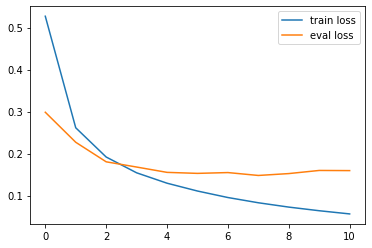

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 76% ok and 24% ko (out of 1000 samples tested)
test_duration: 0:00:02.313664
full_test_duration: 0:45:46.254390
accuracy: 0.76
episode:1
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.284744
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
           Word                                       Audio Pronunciation
0  annomination  LL-Q150 (fra)-WikiLucas00-annomination.wav   anɔminasjɔ̃
epoch:1/100 (187s) train_loss:0.52, eval_loss:0.30
epoch:2/100 (179s) train_loss:0.26, eval_loss:0.23
NEW BEST eval_loss:0.23
epoch:3/100 (180s) train_loss:0.19, eval_loss:0.19
NEW BEST eval_loss:0.19
epoch:4/100 (179s) train_loss:0

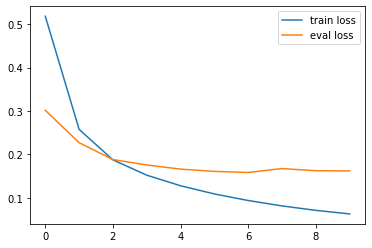

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 74% ok and 26% ko (out of 1000 samples tested)
test_duration: 0:00:02.510173
full_test_duration: 0:30:15.929861
accuracy: 0.74
episode:2
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.216008
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
       Word                                Audio Pronunciation
0  sidérite  LL-Q150 (fra)-LoquaxFR-sidérite.wav       sideʁit
epoch:1/100 (180s) train_loss:0.52, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.26, eval_loss:0.23
NEW BEST eval_loss:0.23
epoch:3/100 (179s) train_loss:0.19, eval_loss:0.19
NEW BEST eval_loss:0.19
epoch:4/100 (179s) train_loss:0.16, eval_loss:0.18
NE

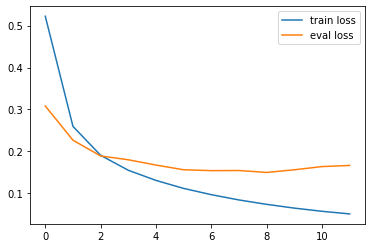

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 78% ok and 22% ko (out of 1000 samples tested)
test_duration: 0:00:02.315990
full_test_duration: 0:35:58.903152
accuracy: 0.78
episode:3
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.294410
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
        Word                                    Audio Pronunciation
0  floraître  LL-Q150 (fra)-WikiLucas00-floraître.wav       flɔʁɛtʁ
epoch:1/100 (180s) train_loss:0.54, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.27, eval_loss:0.23
NEW BEST eval_loss:0.23
epoch:3/100 (179s) train_loss:0.20, eval_loss:0.20
NEW BEST eval_loss:0.20
epoch:4/100 (179s) train_loss:0.16, eval_lo

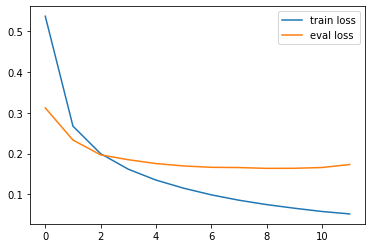

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 74% ok and 26% ko (out of 1000 samples tested)
test_duration: 0:00:02.334789
full_test_duration: 0:35:59.470459
accuracy: 0.74
episode:4
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.296054
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
        Word                                    Audio Pronunciation
0  déchâtier  LL-Q150 (fra)-WikiLucas00-déchâtier.wav       deʃɑtje
epoch:1/100 (180s) train_loss:0.53, eval_loss:0.31
epoch:2/100 (180s) train_loss:0.26, eval_loss:0.23
NEW BEST eval_loss:0.23
epoch:3/100 (179s) train_loss:0.19, eval_loss:0.20
NEW BEST eval_loss:0.20
epoch:4/100 (179s) train_loss:0.15, eval_lo

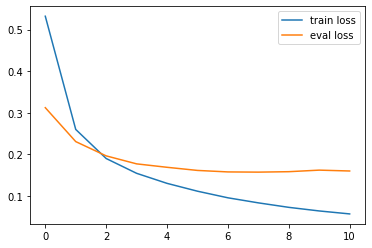

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 75% ok and 25% ko (out of 1000 samples tested)
test_duration: 0:00:02.294844
full_test_duration: 0:32:59.101256
accuracy: 0.75
episode:5
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.179278
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
          Word                                      Audio Pronunciation
0  buccinateur  LL-Q150 (fra)-WikiLucas00-buccinateur.wav    byksinatœʁ
epoch:1/100 (179s) train_loss:0.52, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.26, eval_loss:0.22
NEW BEST eval_loss:0.22
epoch:3/100 (179s) train_loss:0.19, eval_loss:0.19
NEW BEST eval_loss:0.19
epoch:4/100 (179s) train_loss:0.15,

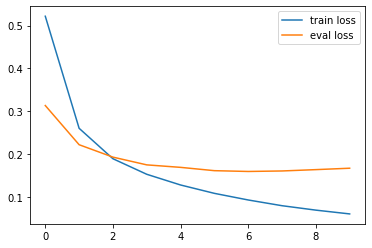

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 73% ok and 27% ko (out of 1000 samples tested)
test_duration: 0:00:02.321347
full_test_duration: 0:29:59.915010
accuracy: 0.73
episode:6
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.299622
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
    Word                           Audio Pronunciation
0  dalle  LL-Q150 (fra)-0x010C-dalle.wav           dal
epoch:1/100 (179s) train_loss:0.54, eval_loss:0.31
epoch:2/100 (180s) train_loss:0.26, eval_loss:0.23
NEW BEST eval_loss:0.23
epoch:3/100 (180s) train_loss:0.19, eval_loss:0.19
NEW BEST eval_loss:0.19
epoch:4/100 (179s) train_loss:0.16, eval_loss:0.17
NEW BEST eval_loss

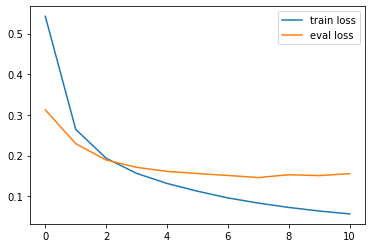

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 72% ok and 28% ko (out of 1000 samples tested)
test_duration: 0:00:02.299681
full_test_duration: 0:33:02.670655
accuracy: 0.72
episode:7
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.181200
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
                  Word                                              Audio  \
0  vouloir mal de mort  LL-Q150 (fra)-WikiLucas00-vouloir mal de mort.wav   

    Pronunciation  
0  vulwaʁmaldəmɔʁ  
epoch:1/100 (179s) train_loss:0.52, eval_loss:0.32
epoch:2/100 (179s) train_loss:0.26, eval_loss:0.24
NEW BEST eval_loss:0.24
epoch:3/100 (179s) train_loss:0.19, eval_loss:0.21
NEW BEST

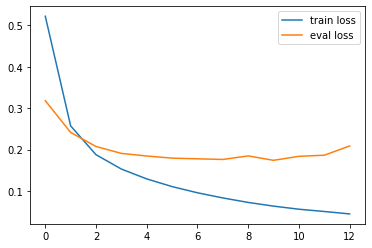

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 76% ok and 24% ko (out of 1000 samples tested)
test_duration: 0:00:02.319690
full_test_duration: 0:39:00.814782
accuracy: 0.76
episode:8
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.188249
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
         Word                                  Audio Pronunciation
0  elliptique  LL-Q150 (fra)-LoquaxFR-elliptique.wav       eliptik
epoch:1/100 (179s) train_loss:0.53, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.27, eval_loss:0.24
NEW BEST eval_loss:0.24
epoch:3/100 (179s) train_loss:0.20, eval_loss:0.19
NEW BEST eval_loss:0.19
epoch:4/100 (179s) train_loss:0.17, eval_loss

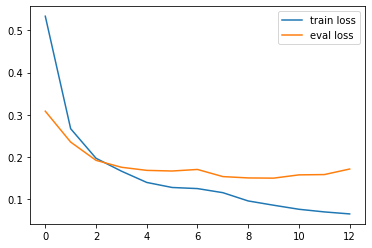

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 74% ok and 26% ko (out of 1000 samples tested)
test_duration: 0:00:02.300074
full_test_duration: 0:38:56.790892
accuracy: 0.74
episode:9
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.288600
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
              Word                                         Audio Pronunciation
0  en pleine santé  LL-Q150 (fra)-Jules78120-en pleine santé.wav   ɑ̃plɛnsɑ̃te
epoch:1/100 (180s) train_loss:0.52, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.26, eval_loss:0.22
NEW BEST eval_loss:0.22
epoch:3/100 (179s) train_loss:0.19, eval_loss:0.20
NEW BEST eval_loss:0.20
epoch:4/100 (179s) tr

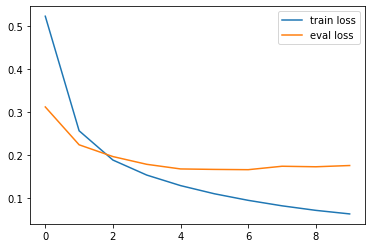

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 76% ok and 24% ko (out of 1000 samples tested)
test_duration: 0:00:02.341011
full_test_duration: 0:29:58.691709
accuracy: 0.76
episode:10
preprocess source_file: fr_wiktionary_alpha.csv
preprocess_data speakers: ['']
len indexes_to_drop: 0
preprocess dest_file: fr_wiktionary_excerpt.csv
preprocess_data_duration: 0:00:05.175887
n_samples:80326 in fr_wiktionary_excerpt.csv
fit: batches:3966 (train:3927, eval:39)
fit: train_samples:78540, eval_samples:780
dictionary_file: fr_wiktionary_excerpt.csv
           Word                                  Audio Pronunciation
0  troisanniste  LL-Q150 (fra)-Lyokoï-troisanniste.wav    tʁwazanist
epoch:1/100 (179s) train_loss:0.53, eval_loss:0.31
epoch:2/100 (179s) train_loss:0.27, eval_loss:0.24
NEW BEST eval_loss:0.24
epoch:3/100 (179s) train_loss:0.20, eval_loss:0.20
NEW BEST eval_loss:0.20
epoch:4/100 (179s) train_loss:0.16, eval

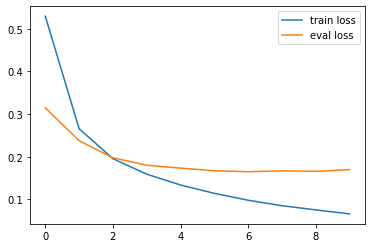

test: 50 bacthes of 20 samples
test: samples:1000
..................................................
Prediction results: 75% ok and 25% ko (out of 1000 samples tested)
test_duration: 0:00:02.306259
full_test_duration: 0:30:05.279710
accuracy: 0.75

mean percentages of words OK across episodes: 0.75
standard deviation of words OK across episodes: 0.02


In [32]:
def clean_train_and_test(config):
    
    global DONE_ONCE_PER_EPISODE
    
    assert datasets_available_locally(config)
    
    print_model_summary()
    
    accuracies = np.zeros(config['episodes'])
    
    for episode in range(config['episodes']):
        
        print('episode:%d' % episode)
        DONE_ONCE_PER_EPISODE = False
        # prepare data, new shuffle should be done at each episode
        t0 = datetime.now()
        config = preprocess_data(config)
        t1 = datetime.now()
        preprocess_data_duration = t1 - t0
        print('preprocess_data_duration:', preprocess_data_duration)
        
        # prepare batches of data
        n_samples = pd.read_csv(config['dictionary_file'], sep='\t', comment='#').shape[0]
        print('n_samples:%d in %s' % (n_samples, config['dictionary_file']))
        n_per_batch = config['n_per_batch']
        n_train = config['n_train']      
        if int(n_train // n_per_batch) * n_per_batch > n_samples - config['n_test']:            
            config['n_train'] = int((n_samples - config['n_test'])// n_per_batch) * n_per_batch
            print('old n_train:%d -> new n_train:%d' % (n_train, config['n_train']))            
        
        # train and test model
        t0 = datetime.now()
        model, n_ok, n_ko = train_and_test(config, episode)
        t1 = datetime.now()
        full_test_duration = t1 - t0
        print('full_test_duration:', full_test_duration)
        accuracy = int(n_ok/(n_ok+n_ko)*100)/100
        print('accuracy:', accuracy)
        
        accuracies[episode] = accuracy

    print('')
    print("mean percentages of words OK across episodes: %.2f" % accuracies.mean())
    print("standard deviation of words OK across episodes: %.2f" % accuracies.std())

    # return the latest model
    return model

#CONFIG['fit_on_accuracy'] = True
model = clean_train_and_test(CONFIG)

## Statistics

In [33]:
def predict_all_samples(config):
    
    # load model
    model = ASR(config)    
    model.to(device)
    model.load_state_dict(torch.load(config['model_filename']))
    model.eval()

    old_n_per_batch = config['n_per_batch']
    config['n_per_batch'] = 1000    
    
    t0 = datetime.now()  
    accuracy_, n_ok_, n_ko_, targets_, predictions_, df_results = test(model,
                                                                       config,
                                                                       all_samples=True,
                                                                       detailed_results=True,
                                                                       verbose1 = True)      
    t1 = datetime.now()
    full_test_duration = t1 - t0
    print('')
    print('full_test_duration:', full_test_duration)
    print('n_ok_:', n_ok_)
    print('n_ko_:', n_ko_)
    nb_ok_predictions = df_results[df_results.Result==True].shape[0]
    nb_ko_predictions = df_results[df_results.Result==False].shape[0]
    nb_predictions = df_results.shape[0]
    accuracy = int(nb_ok_predictions/nb_predictions*100)/100
    print('nb_ok_predictions:', nb_ok_predictions)
    print('nb_ko_predictions:', nb_ko_predictions)
    print('nb_predictions   :', nb_predictions)
    print('accuracy         :', accuracy)

    config['n_per_batch'] = old_n_per_batch
    
    # return the dataframe results
    return df_results

In [34]:
#df_results_ok = df_results[df_results.Result==True]
#df_results_ok.to_csv('ok_'+CONFIG['dictionary_file'], sep='\t')
#df_results_ko = df_results[df_results.Result==False]
#df_results_ko.to_csv('ko_'+CONFIG['dictionary_file'], sep='\t')

In [35]:
def make_stats(targets, predictions, config):

    # create a copy of char_2_int without \' and <SPACE>
    char_2_int = config['char_2_int']

    target_predicted_couples_ko = Counter({})
    target_letters_predicted_ko = Counter({})
    target_letters_predicted_ok = Counter({})
    n_bad_letters = 0

    # fill a confusion matrix 
    confusion_array = np.zeros((len(char_2_int),len(char_2_int)))
    for i in range(len(targets)):
        target_phonemes = get_phonemes(targets[i])
        prediction_phonemes = get_phonemes(predictions[i])
        for j in range(len(target_phonemes)):
            targeted_letter = target_phonemes[j]
            if j < len(prediction_phonemes):
                predicted_letter = prediction_phonemes[j]
                targeted_letter_index = char_2_int[targeted_letter]
                predicted_letter_index = char_2_int[predicted_letter]
                try:
                    confusion_array[targeted_letter_index, predicted_letter_index] += 1
                except:
                    print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                    (targeted_letter, targets[i], predicted_letter, predictions[i]))
                if predicted_letter != targeted_letter: 
                    key1 = targeted_letter
                    target_letters_predicted_ko[key1] += 1
                    key2 = targeted_letter + '-' + predicted_letter
                    target_predicted_couples_ko[key2] += 1
                    n_bad_letters += 1
                    break # stop counting after first bad letter
                else: 
                    key1 = targeted_letter
                    target_letters_predicted_ok[key1] += 1

    for t in range(confusion_array.shape[0]):
        sum = 0
        for p in range(confusion_array.shape[1]):
            sum += confusion_array[t, p]
        for p in range(confusion_array.shape[1]):
            if sum > 0:
                confusion_array[t, p] = int(round(confusion_array[t, p]/sum*100))

    return confusion_array, target_letters_predicted_ok, target_letters_predicted_ko, target_predicted_couples_ko, n_bad_letters

def plot_confusion_matrix(config, confusion_array):
    # display the confusion matrix
    # create a copy of char map without first two chars (' and SPACE)
    char_2_int = config['char_2_int'].copy()
    del char_2_int["'"]
    del char_2_int[" "]
    print('probability (btw 0 and 100%) that a given IPA phoneme is correctly predicted from audio file:')
    # display the confusion matrix without first 2 rows and first 2 colums
    df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_2_int],
                      columns = [i for i in char_2_int])
    _ = plt.figure(figsize = (14,10))
    _ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
    _ = plt.show()
    _ = plt.savefig('wav2phoneme_pytorch_jupyter.png')

In [36]:
def print_most_common_bad_letters(target_letters_predicted_ok, target_letters_predicted_ko):
    counting_pctg_bad_letters = Counter({})

    for key in target_letters_predicted_ok.keys():
        ok = target_letters_predicted_ok[key]
        ko = target_letters_predicted_ko[key]
        pctg = int(ko / (ko + ok) * 10000)/100
        counting_pctg_bad_letters[key] = pctg
     
    # display the percentage of probability that the IPA phoneme
    # is not correctly extracted from the audio
    print('probability (btw 0 and 100%) that a given IPA phoneme is not extracted from audio file:')
    print(counting_pctg_bad_letters.most_common())

In [37]:
def print_bad_couples(target_predicted_couples_ko, n_letters_ko):
    _target_predicted_couples_ko = Counter({})

    sum = 0.0
    for key in target_predicted_couples_ko.keys():
        _target_predicted_couples_ko[key] = int(target_predicted_couples_ko[key]/n_letters_ko*10000)/100
        sum += _target_predicted_couples_ko[key]
        
    print("percentage of the 10 top_most errors:")
    print('')
    print('sum:%.2f' % sum)
    print("[(targeted_phoneme-predicted_phoneme), percentage]")
    print(_target_predicted_couples_ko.most_common(100))

In [38]:
def print_bad_phonemes(target_letters_predicted_ko, n_letters_ko):
    _target_letters_predicted_ko = Counter({})

    sum = 0.0
    for key in target_letters_predicted_ko.keys():
        _target_letters_predicted_ko[key] = int(target_letters_predicted_ko[key]/n_letters_ko*10000)/100
        sum += _target_letters_predicted_ko[key]

    print("10 top_most worst predicted phonemes:")
    print('')
    print('sum:%.2f' % sum)
    print("[target_phoneme_bady_predicted, percentage]")
    print(_target_letters_predicted_ko)

In [39]:
df_results = predict_all_samples(CONFIG)

test: 80 bacthes of 1000 samples
test: samples:80000
................................................................................
Prediction results: 76% ok and 24% ko (out of 80000 samples tested)

full_test_duration: 0:12:04.885770
n_ok_: 76
n_ko_: 24
nb_ok_predictions: 61100
nb_ko_predictions: 18900
nb_predictions   : 80000
accuracy         : 0.76


In [40]:
df_results[df_results.Result == True]['Pronunciation'].str.len().describe()

count    61100.000000
mean         7.510327
std          2.867102
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         18.000000
Name: Pronunciation, dtype: float64

In [42]:
df_results[df_results.Result == False]['Pronunciation'].str.len().describe()

count    18900.000000
mean         8.659365
std          3.073116
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         17.000000
Name: Pronunciation, dtype: float64

In [44]:
df_results[df_results.Result==True].head(3)

,Word,Audio,Pronunciation,Predicted_Pronunciation,Result
0,troisanniste,LL-Q150 (fra)-Lyokoï-troisanniste.wav,tʁwazanist,tʁwazanist,True
1,cinétiquement,LL-Q150 (fra)-WikiLucas00-cinétiquement.wav,sinetikmɑ̃,sinetikmɑ̃,True
3,Hati,LL-Q150 (fra)-LoquaxFR-Hati.wav,ati,ati,True


In [45]:
df_results[df_results.Result==False].sample(100)

,Word,Audio,Pronunciation,Predicted_Pronunciation,Result
65356,savoir,LL-Q150 (fra)-Guilhelma-savoir.wav,savwaʁ,sɛ̃vwaʁ,False
67099,accrétion,LL-Q150 (fra)-LoquaxFR-accrétion.wav,akʁesjɔ̃,akʁɛsjɔ̃,False
49328,neutronisation,LL-Q150 (fra)-WikiLucas00-neutronisation.wav,nøtʁɔnizasjɔ̃,nøtʁonizasjɔ̃,False
20187,je t’en fous,LL-Q150 (fra)-LoquaxFR-je t’en fous.wav,ʒtɑ̃fu,ʃtɑ̃fu,False
49422,optogénétique,LL-Q150 (fra)-Lepticed7-optogénétique.wav,ɔptɔʒenetik,ɔptoʒenetik,False
...,...,...,...,...,...
62868,discrétionnaire,LL-Q150 (fra)-LoquaxFR-discrétionnaire.wav,diskʁesjɔnɛʁ,diskʁɛsjɔnɛʁ,False
67151,YAML,LL-Q150 (fra)-Lepticed7-YAML.wav,iɡʁɛkaɛmɛl,iɡʁaɛkamɛl,False
49434,clandestin,LL-Q150 (fra)-Benoît Prieur-clandestin.wav,klɑ̃dɛstɛ̃,klɑ̃dɛsta,False
26018,papamobile,LL-Q150 (fra)-Flavie (Lyokoï)-papamobile.wav,papamobil,papamɔbil,False


In [47]:
def set_levenshtein(row):
    return Levenshtein.distance(row['Pronunciation'], row['Predicted_Pronunciation'])

df_results['Levenshtein'] = df_results.apply(set_levenshtein, axis=1)
df_results['Levenshtein'].describe()

count    80000.000000
mean         0.313175
std          0.660342
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: Levenshtein, dtype: float64

In [49]:
df_results.sort_values(by=['Levenshtein'], ascending=False).head(10)

,Word,Audio,Pronunciation,Predicted_Pronunciation,Result,Levenshtein
35101,1337,LL-Q150 (fra)-Poslovitch-1337.wav,lit,mitasɑ̃tʁɑ̃mzɔt,False,13
74198,agent innervant,LL-Q150 (fra)-LoquaxFR-agent innervant.wav,aʒɑ̃inɛʁvɑ̃,ɡo,False,11
16369,brut de décoffrage,LL-Q150 (fra)-Jules78120-brut de décoffrage.wav,bʁytdədekɔfʁaʒ,sbɔʁdedtɔʁ,False,10
4709,Michel,LL-Q150 (fra)-Culex-stade Saint-Michel.wav,miʃɛl,stɛ̃dəsɑ̃mʃɛl,False,10
9685,phalange proximale,LL-Q150 (fra)-Vaulque-phalange.wav,falɑ̃ʒpʁɔksimal,falɑ̃ʒ,False,9
46293,analyse calorimétrique,LL-Q150 (fra)-LoquaxFR-analyse calorimétrique.wav,analɔɡʃimik,analiskalɔʁimetik,False,9
17953,àtha,LL-Q150 (fra)-LoquaxFR-àtha.wav,atɔ̃nœ̃blavi,ata,False,9
46903,Wikitionnaire,LL-Q150 (fra)-Benoît Prieur-Wikitionnaire.wav,ɡazaefɛdəsfɛʁ,ɡɔʒifisølɛʁ,False,9
25998,arrondir par défaut,LL-Q150 (fra)-LoquaxFR-arrondir par défaut.wav,aʁɔ̃diʁpaʁdefo,aʁɑ̃diʁ,False,8
39312,Luxembourg,LL-Q150 (fra)-Culex-Lycée Rosa-Luxembourg.wav,lyksɑ̃buʁ,yseʁzɔnb,False,8


In [51]:
predictions = df_results.Predicted_Pronunciation.values
targets = df_results.Pronunciation.values

n_bad_letters: 18246
probability (btw 0 and 100%) that a given IPA phoneme is not extracted from audio file:
[('ɑ', 60.68), ('o', 35.0), ('ŋ', 29.82), ('œ̃', 26.96), ('ɲ', 13.63), ('œ', 10.9), ('ɥ', 8.7), ('ɛ', 8.49), ('ə', 8.46), ('ɡ', 6.73), ('ø', 6.13), ('ɔ', 5.44), ('e', 5.08), ('j', 4.17), ('ɛ̃', 4.06), ('v', 3.63), ('u', 3.59), ('w', 3.52), ('n', 3.46), ('b', 3.29), ('p', 3.03), ('l', 2.86), ('ʒ', 2.4), ('t', 2.34), ('f', 2.28), ('y', 2.17), ('k', 2.12), ('ʃ', 2.04), ('d', 1.98), ('i', 1.87), ('z', 1.85), ('m', 1.77), ('ʁ', 1.66), ('ɑ̃', 1.62), ('a', 1.56), ('ɔ̃', 1.37), ('s', 1.31)]
probability (btw 0 and 100%) that a given IPA phoneme is correctly predicted from audio file:


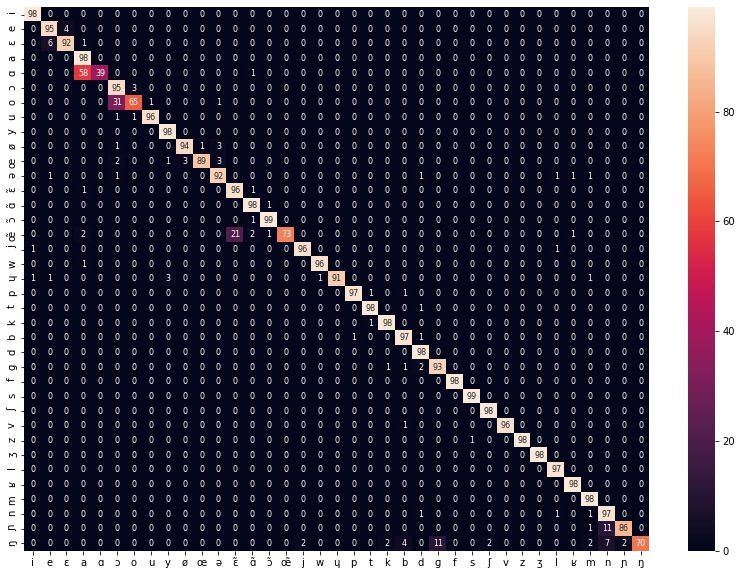

percentage of the 10 top_most errors:

sum:95.65
[(targeted_phoneme-predicted_phoneme), percentage]
[('o-ɔ', 12.03), ('e-ɛ', 6.51), ('ɛ-e', 5.46), ('ɑ-a', 3.16), ('ɔ-o', 3.07), ('t-d', 1.25), ('ɛ-a', 1.04), ('a-ɑ', 0.83), ('i-j', 0.75), ('i-e', 0.73), ('k-t', 0.71), ('ɡ-d', 0.7), ('n-m', 0.7), ('s-z', 0.67), ('j-i', 0.66), ('ə-m', 0.66), ('b-p', 0.59), ('b-d', 0.57), ('z-s', 0.54), ('n-l', 0.52), ('k-p', 0.52), ('t-p', 0.52), ('œ-ə', 0.52), ('ə-l', 0.51), ('ø-ə', 0.5), ('p-t', 0.5), ('ɑ̃-ɔ̃', 0.5), ('ɔ-ə', 0.49), ('a-ɛ', 0.47), ('ɲ-n', 0.47), ('ɡ-b', 0.46), ('t-k', 0.46), ('p-b', 0.43), ('ʁ-ə', 0.43), ('a-ɔ', 0.43), ('œ-ø', 0.42), ('n-d', 0.41), ('l-a', 0.4), ('e-ə', 0.39), ('p-k', 0.39), ('j-l', 0.38), ('ʁ-a', 0.37), ('a-ɛ̃', 0.37), ('œ̃-ɛ̃', 0.37), ('ɡ-k', 0.37), ('d-ə', 0.36), ('l-ə', 0.34), ('l-i', 0.34), ('i-l', 0.34), ('e-i', 0.33), ('o-u', 0.33), ('e-a', 0.32), ('t-s', 0.32), ('ɛ̃-a', 0.31), ('ɔ̃-ɑ̃', 0.3), ('ə-ʁ', 0.3), ('u-ɔ', 0.3), ('v-b', 0.3), ('ə-e', 0.29), ('ɛ̃-ɑ̃', 0.29)

<Figure size 432x288 with 0 Axes>

In [52]:
stats = make_stats(targets, predictions, CONFIG)
confusion_array, target_letters_predicted_ok, target_letters_predicted_ko, target_predicted_couples_ko, n_letters_ko = stats
print('n_bad_letters:', n_letters_ko)
print_most_common_bad_letters(target_letters_predicted_ok, target_letters_predicted_ko)
plot_confusion_matrix(CONFIG, confusion_array)
print_bad_couples(target_predicted_couples_ko, n_letters_ko)
print_bad_phonemes(target_letters_predicted_ko, n_letters_ko)

In [53]:
df_res_o = df_results[df_results.Result == False]\
[df_results.Predicted_Pronunciation.str.contains('ɔ')]\
[df_results.Pronunciation.str.contains('o')]
if df_res_o.shape[0]>=1:
    print(df_res_o[['Word', 'Pronunciation', 'Predicted_Pronunciation']])

                   Word   Pronunciation Predicted_Pronunciation
17           vobulateur       vobylatœʁ               vɔbylatœʁ
56              composé         kɔ̃poze                 kɔ̃pwze
63         l’autre jour         lotʁʒuʁ                lɔtʁəʒuʁ
70            kalimotxo       kalimotʃo               kalimɔtʃo
71     théorie de jauge      teoʁidəʒoʒ              teɔʁidəʒoʒ
...                 ...             ...                     ...
79824      mobilophoner      mobilofɔne              mɔbilɔfɔne
79865   co-incinération  koɛ̃sineʁasjɔ̃          kɔɛ̃sineʁasjɔ̃
79881      écoconcevoir    ekokɔ̃səvwaʁ            ekɔkɔ̃səvwaʁ
79883        bloc-notes         bloknɔt                 plɔknɔt
79886    nanophotonique     nanofɔtɔnik             nanɔfɔtɔnik

[2760 rows x 3 columns]


Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


## Functions for generating the Latex tables of the paper

In [54]:
ipa_to_latex = {
    'i': '\\textipa{i}',
    'e': '\\textipa{e}',
    'ɛ': '\\textipa{E}',
    'a': '\\textipa{a}',
    'ɑ': '\\textipa{A}',
    'ɔ': '\\textipa{O}',
    'o': '\\textipa{o}',
    'u': '\\textipa{u}',
    'y': '\\textipa{y}',
    'ø': '\\textipa{\\o}',
    'œ': '\\textipa{\\oe}',
    'ə': '\\textipa{@}',
    'ɛ̃': '\\textipa{\\~E}',
    'ɑ̃': '\\textipa{\\~A}',
    'ɔ̃': '\\textipa{\\~O}',
    'œ̃': '\\textipa{\\~\\oe}',
    'j': '\\textipa{j}',
    'w': '\\textipa{w}',
    'ɥ': '\\textipa{4}',
    'p': '\\textipa{p}',
    't': '\\textipa{t}',
    'k': '\\textipa{k}',
    'b': '\\textipa{b}',
    'd': '\\textipa{d}',
    'ɡ': '\\textipa{g}',
    'f': '\\textipa{f}',
    's': '\\textipa{s}',
    'ʃ': '\\textipa{S}',
    'v': '\\textipa{v}',
    'z': '\\textipa{z}',
    'ʒ': '\\textipa{Z}',
    'l': '\\textipa{l}',
    'ʁ': '\\textipa{K}',
    'm': '\\textipa{m}',
    'n': '\\textipa{n}',
    'ɲ': '\\textipa{\\textltailn}',
    'ŋ': '\\textipa{N}',

}

In [55]:
ipa_latex_code = {
    'i': 'i',
    'e': 'e',
    'ɛ': 'E',
    'a': 'a',
    'ɑ': 'A',
    'ɔ': 'O',
    'o': 'o',
    'u': 'u',
    'y': 'y',
    'ø': '\\o',
    'œ': '\\oe',
    'ə': '@',
    'ɛ̃': '\\~E',
    'ɑ̃': '\\~A',
    'ɔ̃': '\\~O',
    'œ̃': '\\~\\oe',
    'j': 'j',
    'w': 'w',
    'ɥ': '4',
    'p': 'p',
    't': 't',
    'k': 'k',
    'b': 'b',
    'd': 'd',
    'ɡ': 'g',
    'f': 'f',
    's': 's',
    'ʃ': 'S',
    'v': 'v',
    'z': 'z',
    'ʒ': 'Z',
    'l': 'l',
    'ʁ': 'K',
    'm': 'm',
    'n': 'n',
    'ɲ': '\\textltailn',
    'ŋ': 'N',

}

In [56]:
def print_bad_phonemes_latex(target_letters_predicted_ok, target_letters_predicted_ko):
    
    _target_letters_prediction_accuracy = Counter({})

    for key in target_letters_predicted_ko.keys():
        pctg_bad = round(target_letters_predicted_ok[key]/
                       (target_letters_predicted_ok[key] + target_letters_predicted_ko[key])*100)/100
                       
        _target_letters_prediction_accuracy[key] = pctg_bad
    
    prefix = '''
    \\begin{table}[h!]
    \\begin{center}
    \\begin{tabular}{c c c c} 
      \\hline
      Target Phoneme & Predictions ok & Predictions ko & Accuracy \\\\
      \\hline
    '''
    
    text = prefix
    
    for letter, val in reversed(_target_letters_prediction_accuracy.most_common(100)):
        nb_ok = target_letters_predicted_ok[letter]
        nb_ko = target_letters_predicted_ko[letter]
        accuracy = _target_letters_prediction_accuracy[letter]
        if accuracy * 100 % 10 == 0:
            str_accuracy = str(accuracy) + '0'
        else:
            str_accuracy = str(accuracy)
        text += '      ' + ipa_to_latex[letter] + ' & \\num{' + str(nb_ok) + '}' \
        + ' & \\num{' + str(nb_ko) + '}' + ' & \\num{' + str_accuracy + '} \\\\\n'
    
    suffix = '''      \\hline
    \\newline
    \\end{tabular}
    \\caption{Average accuracy of each phoneme}
    \\label{tab:bad_phonemes}
    \\end{center}
    \\end{table}
    '''
    
    text += suffix
    
    return text

print(print_bad_phonemes_latex(target_letters_predicted_ok, target_letters_predicted_ko))


    \begin{table}[h!]
    \begin{center}
    \begin{tabular}{c c c c} 
      \hline
      Target Phoneme & Predictions ok & Predictions ko & Accuracy \\
      \hline
          \textipa{A} & \num{392} & \num{605} & \num{0.39} \\
      \textipa{o} & \num{4615} & \num{2485} & \num{0.65} \\
      \textipa{N} & \num{40} & \num{17} & \num{0.70} \\
      \textipa{\~\oe} & \num{241} & \num{89} & \num{0.73} \\
      \textipa{\textltailn} & \num{697} & \num{110} & \num{0.86} \\
      \textipa{\oe} & \num{2459} & \num{301} & \num{0.89} \\
      \textipa{4} & \num{1185} & \num{113} & \num{0.91} \\
      \textipa{E} & \num{15859} & \num{1472} & \num{0.92} \\
      \textipa{@} & \num{7918} & \num{732} & \num{0.92} \\
      \textipa{g} & \num{5911} & \num{427} & \num{0.93} \\
      \textipa{\o} & \num{2587} & \num{169} & \num{0.94} \\
      \textipa{O} & \num{18655} & \num{1074} & \num{0.95} \\
      \textipa{e} & \num{30018} & \num{1608} & \num{0.95} \\
      \textipa{w} & \num{4357} & \num{159} & 

In [57]:
def print_bad_couples_latex(target_predicted_couples_ko, n_letters_ko, n_top):
    _target_predicted_couples_ko = Counter({})

    for key in target_predicted_couples_ko.keys():
        _target_predicted_couples_ko[key] = int(target_predicted_couples_ko[key]/n_letters_ko*10000)/100
        

    prefix = '''
    \\begin{table}[h!]
    \\begin{center}
    \\begin{tabular}{c c c} 
      \\hline
      Target Phoneme & Predicted Phoneme & Percentage of incorrect prediction  \\\\
      \\hline
    '''
    
    text = prefix
    
    counter = 0
    for bad_couple, val in _target_predicted_couples_ko.most_common(n_top):
        letters = bad_couple.split('-')
        pctg = _target_predicted_couples_ko[bad_couple]
        text += '      ' + ipa_to_latex[letters[0]] + ' & ' + \
        ipa_to_latex[letters[1]] + ' & \\num{' + str(pctg) + '} \\\\\n'
    
    suffix = '''      \\hline
    \\newline
    \\end{tabular}
    \\caption{Most encountered error pairs}
    \\label{tab:topmost_bad_predictions}
    \\end{center}
    \\end{table}
    '''
    
    text += suffix
    
    return text

print(print_bad_couples_latex(target_predicted_couples_ko, n_letters_ko, 20))


    \begin{table}[h!]
    \begin{center}
    \begin{tabular}{c c c} 
      \hline
      Target Phoneme & Predicted Phoneme & Percentage of incorrect prediction  \\
      \hline
          \textipa{o} & \textipa{O} & \num{12.03} \\
      \textipa{e} & \textipa{E} & \num{6.51} \\
      \textipa{E} & \textipa{e} & \num{5.46} \\
      \textipa{A} & \textipa{a} & \num{3.16} \\
      \textipa{O} & \textipa{o} & \num{3.07} \\
      \textipa{t} & \textipa{d} & \num{1.25} \\
      \textipa{E} & \textipa{a} & \num{1.04} \\
      \textipa{a} & \textipa{A} & \num{0.83} \\
      \textipa{i} & \textipa{j} & \num{0.75} \\
      \textipa{i} & \textipa{e} & \num{0.73} \\
      \textipa{k} & \textipa{t} & \num{0.71} \\
      \textipa{g} & \textipa{d} & \num{0.7} \\
      \textipa{n} & \textipa{m} & \num{0.7} \\
      \textipa{s} & \textipa{z} & \num{0.67} \\
      \textipa{j} & \textipa{i} & \num{0.66} \\
      \textipa{@} & \textipa{m} & \num{0.66} \\
      \textipa{b} & \textipa{p} & \num{0.59} \\
   

In [58]:
def print_levenshtein_top_max_distances(df, n_max):
    counting_pctg_bad_letters = Counter({})

    prefix = '''
    \\begin{table}[h!]
    \\begin{center}
    \\begin{tabular}{c c c c} 
      \\hline
      Word & \\gls{ipa} Target & \\gls{ipa} Prediction & Levenshtein distance \\\\
      \\hline
    '''
    
    text = prefix
    
    for _, row in df_results.sort_values(by=['Levenshtein'], ascending=False).head(n_max).iterrows():
        word = row['Word']
        audio = row['Audio']
        
        target = row['Pronunciation']
        latex_target = '/'
        for i in range(len(target)):
            t = target[i]
            if target[i] == '̃':
                continue
            if i < (len(target)-1) and target[i+1] == '̃':
                t += target[i+1]
                i += 1                
            latex_target += ipa_to_latex[t]
        latex_target += '/'
        
        prediction = row['Predicted_Pronunciation']        
        latex_prediction = '/'
        for i in range(len(prediction)):
            t = prediction[i]
            if prediction[i] == '̃':
                continue
            if i < (len(prediction)-1) and prediction[i+1] == '̃':
                t += prediction[i+1]
                i += 1 
            latex_prediction += ipa_to_latex[t]
        latex_prediction += '/'
        
        distance = row['Levenshtein']
        text += '      ' + word + ' & ' + latex_target + ' & '\
        + latex_prediction + ' & ' + str(distance) + ' \\\\\n'
    
    suffix = '''      \\hline
    \\newline
    \\end{tabular}
    \\caption{Top-10 pronunciations with the highest Levenshtein distance}
    \\label{tab:top_levenshtein_distances}
    \\end{center}
    \\end{table}
    '''
    
    text += suffix
    
    return text

print(print_levenshtein_top_max_distances(df_results, 10))


    \begin{table}[h!]
    \begin{center}
    \begin{tabular}{c c c c} 
      \hline
      Word & \gls{ipa} Target & \gls{ipa} Prediction & Levenshtein distance \\
      \hline
          1337 & /\textipa{l}\textipa{i}\textipa{t}/ & /\textipa{m}\textipa{i}\textipa{t}\textipa{a}\textipa{s}\textipa{\~A}\textipa{t}\textipa{K}\textipa{\~A}\textipa{m}\textipa{z}\textipa{O}\textipa{t}/ & 13 \\
      agent innervant & /\textipa{a}\textipa{Z}\textipa{\~A}\textipa{i}\textipa{n}\textipa{E}\textipa{K}\textipa{v}\textipa{\~A}/ & /\textipa{g}\textipa{o}/ & 11 \\
      brut de décoffrage & /\textipa{b}\textipa{K}\textipa{y}\textipa{t}\textipa{d}\textipa{@}\textipa{d}\textipa{e}\textipa{k}\textipa{O}\textipa{f}\textipa{K}\textipa{a}\textipa{Z}/ & /\textipa{s}\textipa{b}\textipa{O}\textipa{K}\textipa{d}\textipa{e}\textipa{d}\textipa{t}\textipa{O}\textipa{K}/ & 10 \\
      Michel & /\textipa{m}\textipa{i}\textipa{S}\textipa{E}\textipa{l}/ & /\textipa{s}\textipa{t}\textipa{\~E}\textipa{d}\textipa{@}\text